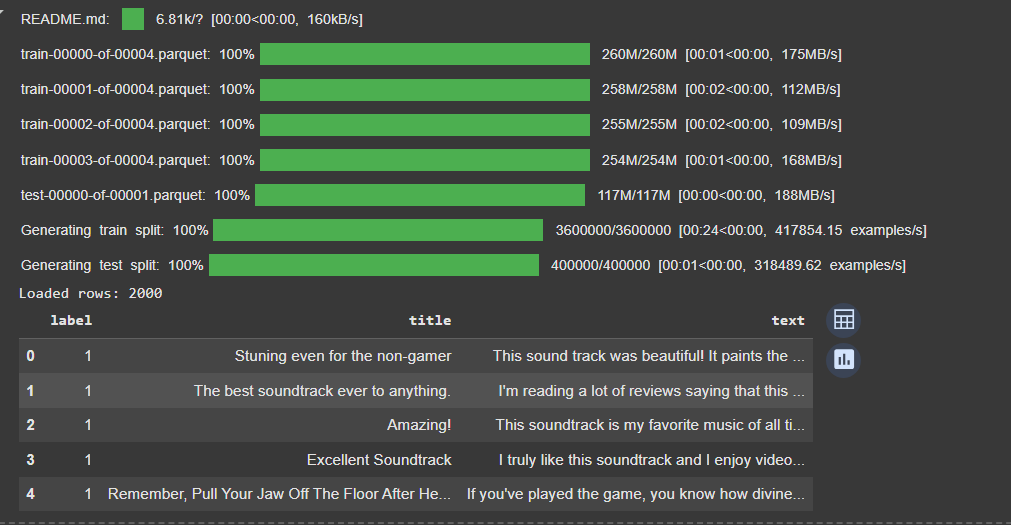

# Dagster Pipeline with Amazon Product Reviews

Data collection, markup, cleaning, and active learning; automating the process using Dagster; and understanding how to improve data using entropy and active learning metrics.

 `amazon_polarity` (Hugging Face dataset) of product reviews.

In [2]:
# Install dependencies (run this cell only once)
!pip install --upgrade pip --quiet
!pip install dagster datasets scikit-learn pandas numpy matplotlib scikit-plot --quiet


In [3]:
# Imports
from dagster import graph, op
import pandas as pd
import numpy as np
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import math
import warnings
warnings.filterwarnings('ignore')


## 1) Data collection

- We use **`amazon_polarity`** because it contains real product reviews and binary sentiment labels
- In practice, replace this with scraped news, API data, or images from OpenImages / Kaggle.
-  **Small subset** (2k rows) so it runs quickly for teaching.

In [4]:
@op
def collect_data_op(n_samples: int = 2000):
    raw = load_dataset('amazon_polarity', split=f'train[:{n_samples}]')
    df = raw.to_pandas()
    df = df.rename(columns={'content': 'text', 'label': 'label'})
    df['label'] = df['label'].astype(int)
    df['text'] = df['text'].astype(str)
    df.to_parquet('amazon_polarity_subset.parquet', index=False)
    return df

# Quick run to collect and show data
df_raw = collect_data_op(2000)
print('Loaded rows:', len(df_raw))
df_raw.head()


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00004.parquet:   0%|          | 0.00/260M [00:00<?, ?B/s]

train-00001-of-00004.parquet:   0%|          | 0.00/258M [00:00<?, ?B/s]

train-00002-of-00004.parquet:   0%|          | 0.00/255M [00:00<?, ?B/s]

train-00003-of-00004.parquet:   0%|          | 0.00/254M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/117M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3600000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/400000 [00:00<?, ? examples/s]

Loaded rows: 2000


,label,title,text
0,1,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,1,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,1,Amazing!,This soundtrack is my favorite music of all ti...
3,1,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,1,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."


### Quick EDA: label balance and text length


Shape: (2000, 3)


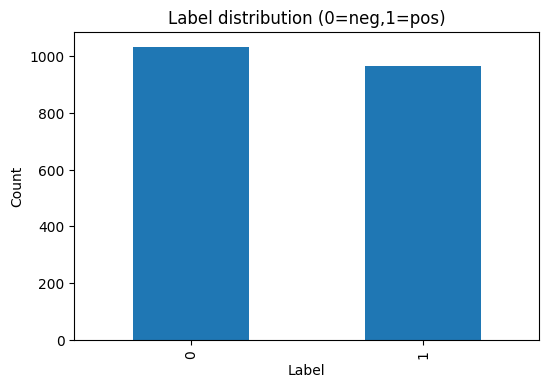

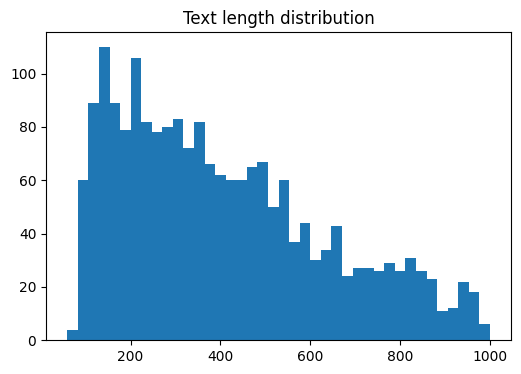

In [5]:
def show_eda(df):
    print('Shape:', df.shape)
    plt.figure(figsize=(6,4))
    df['label'].value_counts().sort_index().plot(kind='bar')
    plt.title('Label distribution (0=neg,1=pos)')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.show()

    df['text_len'] = df['text'].str.len()
    plt.figure(figsize=(6,4))
    plt.hist(df['text_len'], bins=40)
    plt.title('Text length distribution')
    plt.show()

show_eda(df_raw)


## 2) Data markup — automatic labeling and entropy

Simulation of automatic markup by using the dataset's label as `auto_label`. Entropy here is a simple per-sample proxy (binary entropy of the label probability).

In [6]:
@op
def auto_label_op(df: pd.DataFrame):
    df = df.copy()
    df['auto_label'] = df['label'].apply(lambda x: 'positive' if x==1 else 'negative')
    p = df['label'].astype(float)
    df['entropy'] = - (p * np.log2(p + 1e-12) + (1-p) * np.log2(1-p + 1e-12))
    return df

df_marked = auto_label_op(df_raw)
df_marked.head()


,label,title,text,text_len,auto_label,entropy
0,1,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...,394,positive,-1.442823e-12
1,1,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...,470,positive,-1.442823e-12
2,1,Amazing!,This soundtrack is my favorite music of all ti...,750,positive,-1.442823e-12
3,1,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...,721,positive,-1.442823e-12
4,1,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine...",425,positive,-1.442823e-12


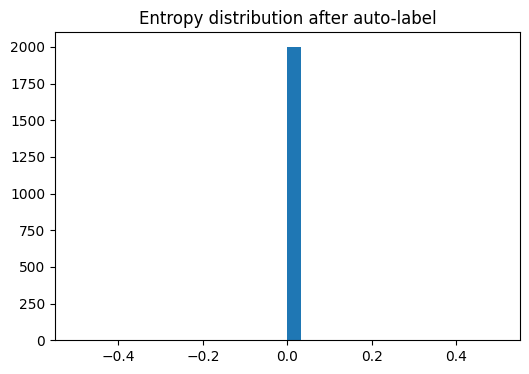

In [7]:
plt.figure(figsize=(6,4))
plt.hist(df_marked['entropy'], bins=30)
plt.title('Entropy distribution after auto-label')
plt.show()


## 3) Data cleanup

Removing duplicates, normalize whitespace, drop too-short texts, and filter extremely long outliers.

In [8]:
@op
def clean_data_op(df: pd.DataFrame):
    df = df.copy()
    df = df.drop_duplicates(subset='text')
    df['text'] = df['text'].str.replace(r'\s+', ' ', regex=True).str.strip()
    df = df[df['text'].str.len() > 10]
    max_len = df['text'].str.len().quantile(0.999)
    df = df[df['text'].str.len() <= math.ceil(max_len)]
    df.reset_index(drop=True, inplace=True)
    return df

df_clean = clean_data_op(df_marked)
print('After cleaning rows:', len(df_clean))
df_clean.head()


After cleaning rows: 1997


,label,title,text,text_len,auto_label,entropy
0,1,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...,394,positive,-1.442823e-12
1,1,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...,470,positive,-1.442823e-12
2,1,Amazing!,This soundtrack is my favorite music of all ti...,750,positive,-1.442823e-12
3,1,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...,721,positive,-1.442823e-12
4,1,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine...",425,positive,-1.442823e-12


## 4) Active learning (uncertainty sampling) — sklearn-based

We vectorize text with TF-IDF, train a RandomForest on a small seed, then iteratively query the most uncertain sample from the pool, add it to training, and retrain. This simulates annotator-in-the-loop.

In [9]:
@op
def active_learning_op(df: pd.DataFrame, n_queries: int = 30):
    df = df.copy()
    texts = df['text'].tolist()
    labels = df['label'].values

    vec = TfidfVectorizer(max_features=6000, ngram_range=(1,2))
    X_all = vec.fit_transform(texts)

    # seed small training set and large pool
    X_train, X_pool, y_train, y_pool = train_test_split(X_all, labels, test_size=0.95, random_state=42, stratify=labels)

    model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)

    accuracies = []
    pool_sizes = []

    queries = min(n_queries, X_pool.shape[0]-1)
    X_train_arr = X_train.toarray() if hasattr(X_train, 'toarray') else X_train
    X_pool_arr = X_pool.toarray()

    for i in range(queries):
        probs = model.predict_proba(X_pool_arr)
        uncertainties = 1 - np.max(probs, axis=1)
        query_idx = int(np.argmax(uncertainties))

        X_new = X_pool_arr[query_idx].reshape(1, -1)
        y_new = np.array([y_pool[query_idx]])
        X_train_arr = np.vstack([X_train_arr, X_new])
        y_train = np.append(y_train, y_new)

        X_pool_arr = np.delete(X_pool_arr, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)

        model.fit(X_train_arr, y_train)

        y_pred_all = model.predict(X_all.toarray())
        acc_all = accuracy_score(labels, y_pred_all)
        accuracies.append(acc_all)
        pool_sizes.append(X_pool_arr.shape[0])

    df['active_label'] = model.predict(X_all.toarray())
    df['active_accuracy'] = accuracies[-1] if len(accuracies)>0 else accuracy_score(labels, model.predict(X_all.toarray()))
    return {"df": df, "accuracies": accuracies, "pool_sizes": pool_sizes, "vectorizer": vec, "model": model}

active_result = active_learning_op(df_clean, n_queries=25)
print('Active learning finished; last accuracy:', active_result['df']['active_accuracy'])


Active learning finished; last accuracy: 0       0.667501
1       0.667501
2       0.667501
3       0.667501
4       0.667501
          ...   
1992    0.667501
1993    0.667501
1994    0.667501
1995    0.667501
1996    0.667501
Name: active_accuracy, Length: 1997, dtype: float64


### Plot active learning accuracy curve

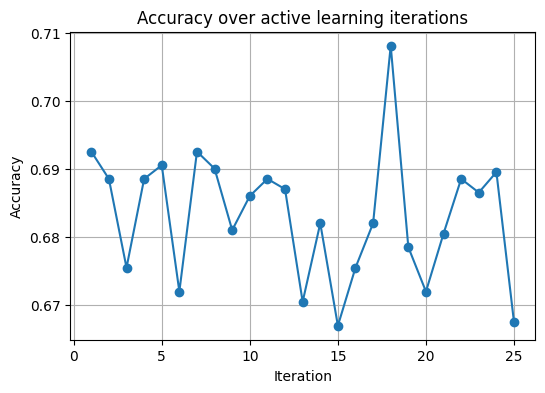

In [10]:
accuracies = active_result['accuracies']
plt.figure(figsize=(6,4))
plt.plot(range(1, len(accuracies)+1), accuracies, marker='o')
plt.title('Accuracy over active learning iterations')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


## 5) Final training and evaluation

Training a final model on the active-labeled data and show confusion matrix.

In [11]:
@op
def train_model_op(active_result: dict):
    df = active_result['df'].copy()
    vec = active_result['vectorizer']
    model = active_result['model']

    X = vec.transform(df['text'].tolist()).toarray()
    y = df['active_label'].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    final_model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
    final_model.fit(X_train, y_train)
    y_pred = final_model.predict(X_test)
    final_acc = accuracy_score(y_test, y_pred)

    df['final_predictions'] = final_model.predict(X)
    df['final_accuracy'] = final_acc
    return {"df": df, "final_model": final_model, "y_test": y_test, "y_pred": y_pred}

final_result = train_model_op(active_result)
print('Final test accuracy:', final_result['df']['final_accuracy'].iloc[0] if 'final_accuracy' in final_result['df'].columns else final_result['y_pred'].shape)


Final test accuracy: 0.7625


<Figure size 600x600 with 0 Axes>

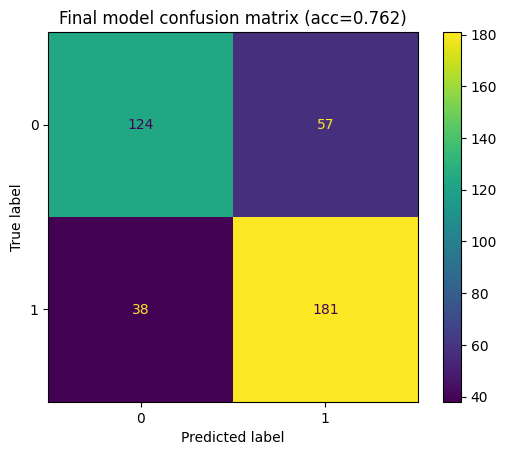

In [12]:
# Confusion matrix
y_test = final_result['y_test']
y_pred = final_result['y_pred']
plt.figure(figsize=(6,6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title(f"Final model confusion matrix (acc={final_result['df']['final_accuracy'].iloc[0]:.3f})")
plt.show()


## Processing

Processed dataset and final result for later use.

In [13]:
final_df = final_result['df']
final_df.to_parquet('amazon_pipeline_result.parquet', index=False)
print('Saved amazon_pipeline_result.parquet')


Saved amazon_pipeline_result.parquet


### Conclusion

- The active learning loop uses the true labels from the pool as a simulated oracle. I  would push queried samples to an annotation UI (Label Studio) and ingest labels back.

